## Importing the libraries and seting the paths

In [1]:
from utils import open_nea_table, download_nea_table
from mass_year import mass_vs_year_plot, planet_discovery_stat
import pandas as pd
import numpy as np
import os
import sys
from datetime import date
import math

from mr_utils import a_from_P, Teq_from_teff_v_plx_a, Teq_from_teff_v_plx_P, teq_hellper_function, a_from_P, MR_plot, creating_R_ML_table

from mr_ml_utils import score_dataset, optuna_RF_Reg, modified_learning_curve, RF_training_with_display
from m_from_r import mass_from_radius

/home/vadibekyan/my_github/ExoPLots/utils.py:52: DtypeWarning: Columns (65,187) have mixed types. Specify dtype option on import or set low_memory=False.
  nea_full_table = pd.read_csv(table_directory)
/home/vadibekyan/my_github/ExoPLots/utils.py:52: DtypeWarning: Columns (65,187) have mixed types. Specify dtype option on import or set low_memory=False.
  nea_full_table = pd.read_csv(table_directory)
/home/vadibekyan/my_github/ExoPLots/mr_utils.py:261: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nea_with_M_and_R_cleaned['Teq'] = 0
/home/vadibekyan/my_github/ExoPLots/mr_utils.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

If needed to update the NEA table then first run  "download_nea_table"

In [30]:
#download_nea_table()

In [31]:
nea_full_table = open_nea_table()
nea_full_table.head(3)

/home/vadibekyan/my_github/ExoPLots/utils.py:52: DtypeWarning:

Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.



,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,gaia_id,default_flag,pl_refname,sy_refname,...,sy_jmagerr1,sy_jmagerr2,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_kmag,sy_kmagerr1,sy_kmagerr2
0,OGLE-TR-10 b,b,OGLE-TR-10,NaN,NaN,TIC 130150682,Gaia DR2 4056443366649948160,1,<a refstr=TORRES_ET_AL__2008 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,NaN,NaN,13.692,13.314,0.121,-0.121,13.314&plusmn;0.121,12.856,NaN,NaN
1,BD-08 2823 c,c,BD-08 2823,NaN,HIP 49067,TIC 33355302,Gaia DR2 3770419611540574080,1,<a refstr=HEBRARD_ET_AL__2010 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.020,-0.020,7.96&plusmn;0.02,7.498,0.047,-0.047,7.498&plusmn;0.047,7.323,0.021,-0.021
2,HR 8799 c,c,HR 8799,HD 218396,HIP 114189,TIC 245368902,Gaia DR2 2832463659640297472,1,<a refstr=MAROIS_ET_AL__2008 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.027,-0.027,5.383&plusmn;0.027,5.280,0.018,-0.018,5.280&plusmn;0.018,5.240,0.018,-0.018


## Selecting columns that are relevant for the ML analysis. 

Equilibrium temperature is important for the radius of hot planets. This parameter will be estimated from the luminosity of the star and the distance of the planet from the star. Luminosity will also be determined here.

In [3]:
relevant_columns = ['pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_orbsmax', 'pl_bmasse', 'pl_masseerr1', 'pl_masseerr2', 'pl_orbper',  'sy_vmag', 'sy_plx', 'st_teff', 'st_mass', 'st_met']
nea_relevant = nea_full_table[relevant_columns]


Selecting planets with Mass and Radius measurements for ML

In [4]:
nea_with_M_and_R = nea_relevant[(nea_relevant.pl_bmasse > 0) & (nea_relevant.pl_rade > 0) ].reset_index(drop=True) # reset index, drop old ones

print (f'There are {len(nea_with_M_and_R)} planets with mass and radius measurements')

nea_with_M_and_R.describe()

There are 1113 planets with mass and radius measurements


,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbsmax,pl_bmasse,pl_masseerr1,pl_masseerr2,pl_orbper,sy_vmag,sy_plx,st_teff,st_mass,st_met
count,1113.000000,1089.000000,1089.000000,878.000000,1113.000000,993.000000,993.000000,1.098000e+03,1110.000000,1085.000000,1032.000000,1100.000000,950.000000
mean,8.967707,0.663302,-0.575284,17.160037,420.861732,62.765269,-59.203874,3.790530e+05,12.274946,9.295143,5483.824806,1.003882,0.051183
std,6.083019,1.022459,0.798818,272.583363,963.110129,243.492003,229.348953,1.213509e+07,2.171725,17.976954,1361.837200,0.345527,0.197215
min,0.310000,0.006000,-6.730000,0.006000,0.070000,0.012000,-4767.450000,2.401040e-01,5.569110,-0.149186,575.000000,0.010000,-0.580000
25%,2.630000,0.119000,-0.695000,0.037958,10.100000,2.120000,-41.317900,3.003277e+00,11.012500,1.939290,5016.000000,0.820000,-0.070000
50%,10.447000,0.336000,-0.325000,0.053735,126.496340,14.937940,-14.302350,4.603155e+00,12.247000,3.516790,5620.000000,1.000000,0.060000
75%,13.787000,0.785000,-0.110000,0.100075,379.000000,43.541000,-2.000000,1.189179e+01,13.688000,7.961470,6009.000000,1.180000,0.190000
max,33.600000,10.536000,0.000000,7506.000000,9534.900000,4767.450000,-0.012000,4.020000e+08,20.154400,153.081000,27730.000000,2.780000,0.522000


There seem to be star(s) with negative parallaxes. They must be removed fromthe sample

In [5]:
nea_with_M_and_R = nea_with_M_and_R[nea_with_M_and_R.sy_plx > 0]

To calculate Teq, one needs Luminosity (us such, Teff, Vmag, and Plx) and semimajor axis (or orbital period ond Mstar)

In [6]:
#check how many nan values have in each column
nea_with_M_and_R.isna().sum()

pl_rade           0
pl_radeerr1      22
pl_radeerr2      22
pl_orbsmax      234
pl_bmasse         0
pl_masseerr1    118
pl_masseerr2    118
pl_orbper        13
sy_vmag           0
sy_plx            0
st_teff          78
st_mass          11
st_met          148
dtype: int64

There are 235 missing entries for semimajor axis. This parameter can be estimated from the stellar mass and orbital period.

Next, all the rows containing nan values will be removed, except if the nan is in the "pl_orbsmax" column

In [7]:
nea_with_M_and_R_cleaned = nea_with_M_and_R.dropna(subset=nea_with_M_and_R.columns.drop(['pl_orbsmax']))
# Check results
nea_with_M_and_R_cleaned.isna().sum()


pl_rade           0
pl_radeerr1       0
pl_radeerr2       0
pl_orbsmax      160
pl_bmasse         0
pl_masseerr1      0
pl_masseerr2      0
pl_orbper         0
sy_vmag           0
sy_plx            0
st_teff           0
st_mass           0
st_met            0
dtype: int64

In [8]:
print (f'There are {len(nea_with_M_and_R_cleaned)} planets for the ML analysis')
nea_with_M_and_R_cleaned.head(3)

There are 828 planets for the ML analysis


,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbsmax,pl_bmasse,pl_masseerr1,pl_masseerr2,pl_orbper,sy_vmag,sy_plx,st_teff,st_mass,st_met
4,16.870,0.560,-0.504,0.0535,271.74465,22.88376,-21.93027,3.899052,12.006,1.73126,5941.0,1.34,0.164
5,21.633,5.044,-5.044,NaN,352.79130,171.62820,-171.62820,2.175180,11.965,1.29679,6100.0,1.87,-0.350
6,12.722,0.538,-0.538,0.0466,180.84527,7.31009,-6.99226,3.652815,13.146,3.30091,5519.0,1.01,0.294


Calculating semimajor axis from Period and stellar mass, for the missing "a" entries

In [9]:
for i in range(len(nea_with_M_and_R_cleaned)):
    if np.isnan(nea_with_M_and_R_cleaned.iloc[i]['pl_orbsmax']):
        nea_with_M_and_R_cleaned.iloc[i]['pl_orbsmax'] = a_from_P(nea_with_M_and_R_cleaned.iloc[i]['st_mass'], nea_with_M_and_R_cleaned.iloc[i]['pl_orbper'])


Calculating Teq from "a" or "P" 

Use teq_hellper_function function to determine Teq from "a" or "P" depending on their availability. Priority is given to "a"

In [10]:
# Add new columns: Teq
nea_with_M_and_R_cleaned['Teq'] = 0

nea_with_M_and_R_cleaned = nea_with_M_and_R_cleaned.apply(lambda x: teq_hellper_function(x, 'pl_orbsmax', 'pl_orbper', 'st_teff', 'sy_vmag', 'sy_plx', 'st_mass', 'Teq'), axis = 1)

/tmp/ipykernel_1033550/293283582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nea_with_M_and_R_cleaned['Teq'] = 0


In [11]:
# very 'cool' planets
print (display(nea_with_M_and_R_cleaned[nea_with_M_and_R_cleaned.Teq < 100]))

#Some of the parameters used to calculate the Teq must be wrong. These objects should be removed

nea_with_M_and_R_cleaned = nea_with_M_and_R_cleaned[nea_with_M_and_R_cleaned.Teq > 10]

,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbsmax,pl_bmasse,pl_masseerr1,pl_masseerr2,pl_orbper,sy_vmag,sy_plx,st_teff,st_mass,st_met,Teq
526,21.196,0.684,-0.594,0.03462,915.35040,266.97720,-266.97720,1.481124e+00,7.55000,4.86254,10170.0,2.52,-0.03,0.0
690,20.288,1.009,-1.009,0.05580,527.59780,38.13960,-38.13960,3.344829e+00,9.94600,2.31187,9360.0,2.07,0.21,0.0
696,18.147,0.235,-0.235,0.05053,632.47853,50.85255,-44.49598,2.724033e+00,6.59776,9.99903,8000.0,2.03,0.29,0.0
1058,12.442,0.336,-0.336,7506.00000,2002.31896,476.74261,-603.87397,4.020000e+08,11.29800,91.82910,3406.0,0.37,0.00,1.0


None


### Selecting plaents with relatively high precision in Mass and Radius

In [12]:
# calculating the mean errors of M and R
nea_with_M_and_R_cleaned['pl_rade_err'] = (nea_with_M_and_R_cleaned['pl_radeerr1'] - nea_with_M_and_R_cleaned['pl_radeerr2'])/2
nea_with_M_and_R_cleaned['pl_bmasse_err'] = (nea_with_M_and_R_cleaned['pl_masseerr1'] - nea_with_M_and_R_cleaned['pl_masseerr2'])/2

In [13]:
M_threshold = 0.5
R_threshold = 0.5
precise_criteria = (nea_with_M_and_R_cleaned['pl_rade_err']/nea_with_M_and_R_cleaned['pl_rade'] < R_threshold) & (nea_with_M_and_R_cleaned['pl_bmasse_err']/nea_with_M_and_R_cleaned['pl_bmasse'] < M_threshold)
nea_with_M_and_R_cleaned_accurate = nea_with_M_and_R_cleaned[precise_criteria]

print (f'There are {len(nea_with_M_and_R_cleaned_accurate)} precisely characterized planets in terms of Mass and Radius')

There are 787 precisely characterized planets in terms of Mass and Radius


In [14]:
# Final table with Mass, Radius, and Teq
nea_MR_final_table = nea_with_M_and_R_cleaned_accurate[['pl_rade', 'pl_bmasse', 'Teq', 'st_teff', 'pl_orbsmax', 'st_met']]
nea_MR_final_table.head(2)

,pl_rade,pl_bmasse,Teq,st_teff,pl_orbsmax,st_met
4,16.870,271.74465,1744.0,5941.0,0.053500,0.164
5,21.633,352.79130,5466.0,6100.0,0.007337,-0.350


# Starting the Machine Learning part

Since the accuracy of Mass estimation is not critical, I'll make things simple (but still keeping the state-of-the-art): 

Use Random Forest regressor and tune HyperParameters with "optuna" (sometimes better than grid_search see e.g. [this](https://medium.com/mlearning-ai/hyper-parameter-tuning-through-grid-search-and-optuna-2bd89a2ece06)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Displaying the data

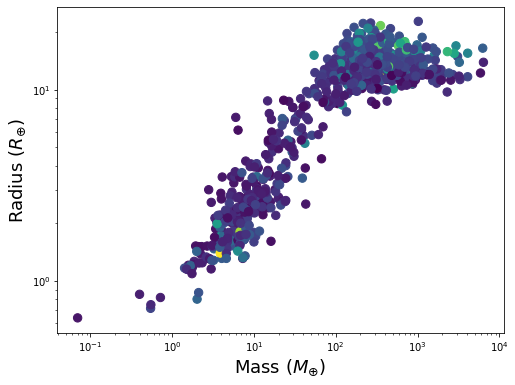

In [16]:
fig = plt.figure(1, figsize = (8,6))
ax = plt.subplot(1,1,1)
MR_plot(ax, nea_MR_final_table.pl_bmasse, nea_MR_final_table.pl_rade, color = nea_MR_final_table['Teq'], label = 'MR data')

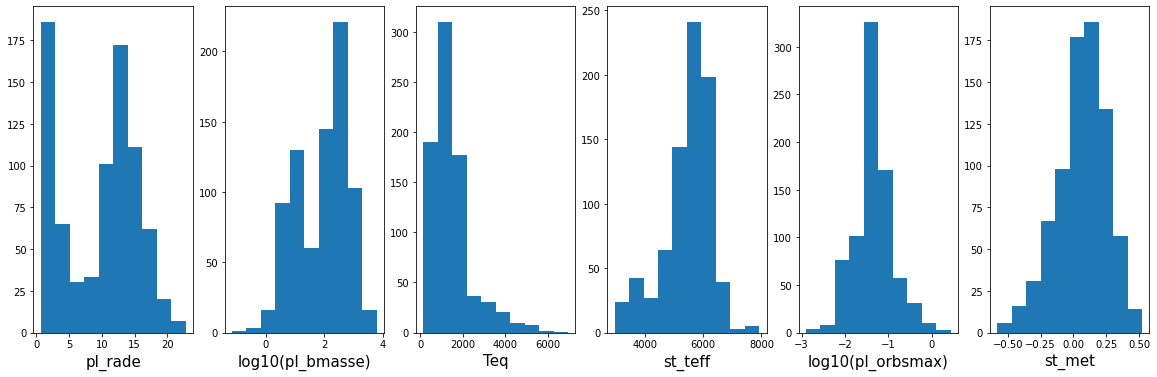

In [17]:
fig = plt.figure(2, figsize = (20,6))
ax = plt.gca()

for i, col  in enumerate(nea_MR_final_table.columns):
    ax = plt.subplot(1, 6, i+1)
    if nea_MR_final_table[col].max() / nea_MR_final_table[col].min() > 1e3:
        ax.hist(np.log10(nea_MR_final_table[col]))
        ax.set_xlabel(f'log10({col})', fontsize = 15)
    else:
        ax.hist((nea_MR_final_table[col]))
        ax.set_xlabel(col, fontsize = 15)

Some of the parameters, including planetary Masses, have very wide distribution. Several parameters do not show symmetric distribution

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

Selecting our target variable ( y = planetary mass) and the input features (X =[Teff, metallicity, radius, orbital semi-major axis, Teq])

In [19]:
y = nea_MR_final_table['pl_bmasse']
X = nea_MR_final_table.drop(columns = ['pl_bmasse'])

### Tuning the hyperparameters using Optuna and fitting the data

The base MAE score from the trainin set is 254


[I 2023-07-13 16:08:45,267] A new study created in memory with name: no-name-390d9433-2ac5-4289-b0f4-9cc9d5751580
[I 2023-07-13 16:08:46,721] Trial 0 finished with value: 249.3077695765656 and parameters: {'n_estimators': 140, 'max_depth': 8, 'min_samples_split': 2, 'max_features': 2}. Best is trial 0 with value: 249.3077695765656.
[I 2023-07-13 16:08:47,605] Trial 1 finished with value: 251.61606408156112 and parameters: {'n_estimators': 80, 'max_depth': 5, 'min_samples_split': 6, 'max_features': 3}. Best is trial 0 with value: 249.3077695765656.
[I 2023-07-13 16:08:49,312] Trial 2 finished with value: 252.25623051938857 and parameters: {'n_estimators': 140, 'max_depth': 7, 'min_samples_split': 6, 'max_features': 3}. Best is trial 0 with value: 249.3077695765656.
[I 2023-07-13 16:08:49,602] Trial 3 finished with value: 254.8820144575678 and parameters: {'n_estimators': 20, 'max_depth': 7, 'min_samples_split': 5, 'max_features': 5}. Best is trial 0 with value: 249.3077695765656.
[I 202


The best hyperparameters for RF Regressor {'n_estimators': 20, 'max_depth': 3, 'min_samples_split': 6, 'max_features': 4}

AME of the BEST RF Regressor: Training data 229.74516441013463
AME of the BEST RF Regressor: Test data 255.90467672903083



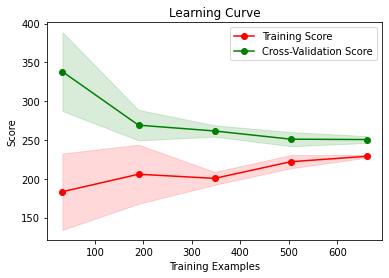

In [20]:
""" 
A smaller value of n_trials can be used to run the code faster

best_model: the untrained RF model with best hyperparameters
final_trained_model_train_data: the best RF model trained on a "training" dataset (85% of the sample)
final_trained_model_full_data: the best RF model trained on the full sample!
"""
best_model, final_trained_model_train_data, final_trained_model_full_data = RF_training_with_display(X,y, test_size = 0.15, n_trials = 100, display = True)

### While the training process involves cross-validation, in the figures below, I show how the process is done on a single example.

- Splitting sample into training and testing sets
- Training the model using the "best" hyperparameters taken from the output of the previous function.
- Showing the original M-R and the predicted M-R diagrams

Sizes of the samples:
Train = 668, Test = 119


Text(0.5, 1.0, 'Training and Test data sets')

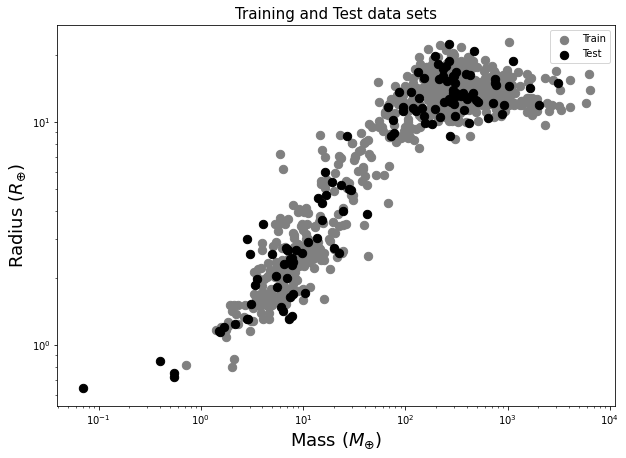

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print (f'Sizes of the samples:\nTrain = {len(X_train)}, Test = {len(X_test)}')

fig = plt.figure(figsize = (10,7))
ax = plt.subplot(1,1,1)
best_model.fit(X_train, y_train)
MR_plot(ax, y_train, X_train.pl_rade, color = 'gray', label = 'Train', xscale = 'log', yscale = 'log')
MR_plot(ax, y_test, X_test.pl_rade, color = 'black', label = 'Test', xscale = 'log', yscale = 'log')
plt.legend(loc = 'best')
plt.title('Training and Test data sets', fontsize = 15)

Text(0.5, 1.0, 'M-R diagram for the original and predicted  TEST data set')

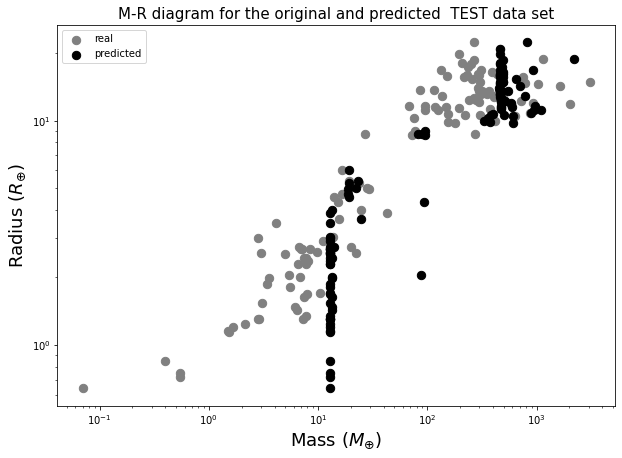

In [36]:
fig = plt.figure(figsize = (10,7))
ax = plt.subplot(1,1,1)
best_model.fit(X_train, y_train)
M_predict_test = best_model.predict(X_test)
MR_plot(ax, y_test, X_test.pl_rade, color = 'gray', label = 'real', xscale = 'log', yscale = 'log')
MR_plot(ax, M_predict_test, X_test.pl_rade, color = 'black', label = 'predicted', xscale = 'log', yscale = 'log')
plt.legend(loc = 'best')

plt.title('M-R diagram for the original and predicted  TEST data set', fontsize = 15)


### After training the model, it is time to predict Masses of planets without mass estimated

In [37]:
# Selects planets without masses, but with relatively high precision (relative precision better than 50%) in R
nea_R_final_table = creating_R_ML_table(nea_full_table)

/home/vadibekyan/my_github/ExoPLots/mr_utils.py:314: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Predicting M from R and other relevant parameters. Displaying the M-R diagram

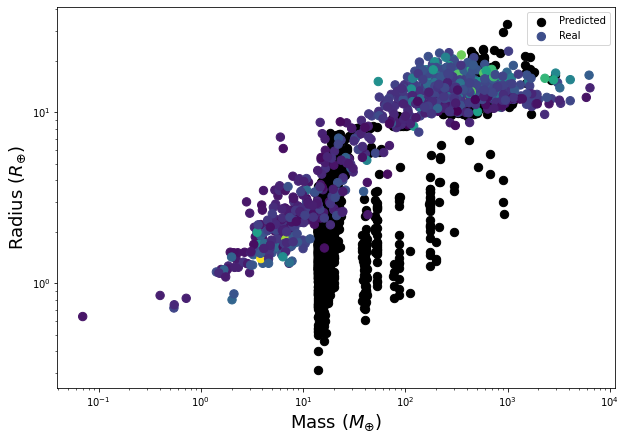

In [25]:
M_pred = final_trained_model_full_data.predict(nea_R_final_table)

fig = plt.figure(figsize = (10,7))
ax = plt.subplot(1,1, 1)
MR_plot(ax, M_pred, nea_R_final_table.pl_rade, color = 'black', label ='Predicted', xscale = 'log', yscale = 'log')
MR_plot(ax, nea_MR_final_table.pl_bmasse, nea_MR_final_table.pl_rade, color = nea_MR_final_table['Teq'], label = 'Real')
plt.legend(loc = 'best')


In [41]:
nea_MR_final_table['pl_bmasse'].median()

160.497

# Training on logarithmic Mass

The masses of planets range from 0.07 to 6388 Mearth, with a mean and median values of ~340 and 160 MEarth. The skewed and bimodal distribution of the masses seems to lead to overestimation of the prediced masses and some 'strange' patterns (this might be also due to overfitting?). Better to train the model on log Masses.

In [26]:
nea_logMR_final_table = nea_MR_final_table.copy()

nea_logMR_final_table['pl_bmasse_log'] = np.log10(nea_logMR_final_table['pl_bmasse'])

y_log = nea_logMR_final_table['pl_bmasse_log']
X_log = nea_logMR_final_table.drop(columns = ['pl_bmasse', 'pl_bmasse_log'])

[I 2023-07-13 16:09:00,683] A new study created in memory with name: no-name-207cd6d1-b585-48cb-a27e-db270b233154


The base MAE score from the trainin set is 0


[I 2023-07-13 16:09:02,156] Trial 0 finished with value: 0.2356909030627003 and parameters: {'n_estimators': 140, 'max_depth': 10, 'min_samples_split': 6, 'max_features': 2}. Best is trial 0 with value: 0.2356909030627003.
[I 2023-07-13 16:09:02,666] Trial 1 finished with value: 0.234560712890387 and parameters: {'n_estimators': 40, 'max_depth': 7, 'min_samples_split': 5, 'max_features': 4}. Best is trial 1 with value: 0.234560712890387.
[I 2023-07-13 16:09:03,586] Trial 2 finished with value: 0.23698559342316877 and parameters: {'n_estimators': 60, 'max_depth': 7, 'min_samples_split': 3, 'max_features': 5}. Best is trial 1 with value: 0.234560712890387.
[I 2023-07-13 16:09:05,239] Trial 3 finished with value: 0.2377474021083667 and parameters: {'n_estimators': 160, 'max_depth': 8, 'min_samples_split': 6, 'max_features': 2}. Best is trial 1 with value: 0.234560712890387.
[I 2023-07-13 16:09:06,775] Trial 4 finished with value: 0.2361515238448136 and parameters: {'n_estimators': 160, 'm


The best hyperparameters for RF Regressor {'n_estimators': 40, 'max_depth': 7, 'min_samples_split': 5, 'max_features': 4}

AME of the BEST RF Regressor: Training data 0.1637487094021415
AME of the BEST RF Regressor: Test data 0.22802392425439902



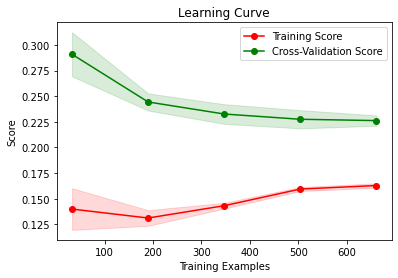

In [27]:
# A smaller value of n_trials can be used to run the code faster
best_model_log, final_model_train_data_log, final_model_full_data_log = RF_training_with_display(X_log,y_log, test_size = 0.15, n_trials = 100)

### Displaying predicted masses based on the model that was trained on log(M)

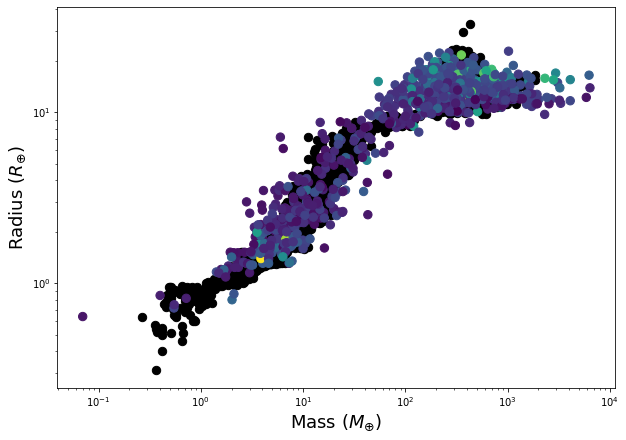

In [28]:
M_predict = np.power(10,final_model_train_data_log.predict(nea_R_final_table))

fig = plt.figure(figsize = (10,7))
ax = plt.subplot(1,1, 1)
MR_plot(ax, M_predict, nea_R_final_table.pl_rade, color = 'black', label = 'predicted', xscale = 'log', yscale = 'log')
MR_plot(ax, nea_MR_final_table.pl_bmasse, nea_MR_final_table.pl_rade, color = nea_MR_final_table['Teq'], label = 'real')

### Overall, the distributions seem to be comparable

# The final code "mr_pl.py"

This is the code that one can run to predict masses from R

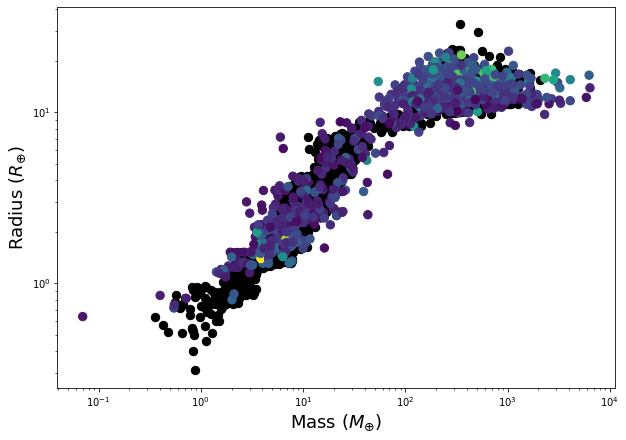

In [29]:
M_pred = mass_from_radius(nea_R_final_table, training = True)
fig = plt.figure(figsize = (10,7))
ax = plt.subplot(1,1, 1)
MR_plot(ax, M_pred, nea_R_final_table.pl_rade, color = 'black', label = 'predicted', xscale = 'log', yscale = 'log')
MR_plot(ax, nea_MR_final_table.pl_bmasse, nea_MR_final_table.pl_rade, color = nea_MR_final_table['Teq'], label = 'real')